In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from palettable.lightbartlein.sequential import Blues7_3, Blues7_7
from palettable.cartocolors.sequential import BluGrn_6, Peach_4
from palettable.colorbrewer.sequential import Blues_7, Oranges_3
from palettable.cmocean.sequential import Amp_17

# The evolution of the four types of stress

In [2]:
company_type = ['company_name', 'GICSSector', 'GICSSubIndustry']  # company type
temporal = ['quarter', 'year', 'half-year']                   # temporal
spatial = ['state','Region', 'Division']                      # spatial

spatio_temporal_columns = company_type + spatial + temporal

In [3]:
CMAP_Q_dict = {
    'Q1': sns.light_palette("seagreen", as_cmap=True),
    'Q2': sns.light_palette("black", as_cmap=True),
    'Q3': sns.light_palette("firebrick", as_cmap=True),
    'Q4': sns.light_palette("gold", as_cmap=True)
}

NOMAP_Q_dict = {
    'Q1': "seagreen",
    'Q2': "black",
    'Q3': "firebrick",
    'Q4': "gold"
}

CMAP_H_dict = {
    'Q1': "-",
    'Q2': "\\",
    'Q3': "+",
    'Q4': "o",
}

sns.set(style="white", font_scale=2.5)

In [4]:
fig_folder = "../../results/"
fig_folder_single_Q = "../../results/"

# Get the master data file

In [5]:
data = pd.read_csv("../../preprocessed/reviews_master_no_text.csv", low_memory=False)

In [6]:
len(data)

463315

In [7]:
# remove a partial quarter
data = data[data["quarter"]!='2020 Q2']
len(data)

460227

# Main functions, general

In [8]:
def find_point_quadrant(s, r):
    """
    here we chose to give negative rating to positive stress
    and positive to the negative stress 
    (for vis purpose, fits better with the colormap that i like)
    we call the function quadrants_scores to get the extent of being
    in the positive or negative quadrant for each company
    """
    def quadrants_scores(x, y):
        """
        input: two arrays of real values x and y,
        representing x and y coordinates of points
        p = (x, y) in the quadrant
        i.e., stress and reputation scores for a company
        output: the array with scores between (0,1) denoting
        the strength of each point's membership in its quadrant


        the function calculates the vector length for the point
        and divides by the radians of its angle with 45 degrees axis


        note that you can enter the points from any quadrant
        and you will always get a score between (0,1)
        so you should note the quadrant's membership outside
        this function
        """
        L = np.sqrt((x)**2+(y)**2) # radius
        cos_alpha = np.abs(x) / L
        cos_beta = np.abs(y) / L
        alpha = np.arccos(cos_alpha) # the angle from x-axis
        beta = np.arccos(cos_beta) # the angle from y-axis
        angle_centre = math.acos(math.pi/4.0) # 45 degree angle
        angle_from_centre_x = np.array(np.abs(alpha - angle_centre))
        angle_from_centre_y = np.array((np.abs(beta - angle_centre)))
        angle_from_centre = np.fmax(angle_from_centre_x, angle_from_centre_y) # we select the larger of the two angles

        res = L / (angle_from_centre + math.pi)

        return res

    if s<=0 and r>=0:
        Q = "Q1_Low_Strain"
    elif s<=0 and r<0:
        Q = "Q2_Passive"
    elif s>0 and r<0:
        Q = "Q3_Neg"
    elif s>0 and r>=0:
        Q = "Q4_Pos"    
    return Q + " " + str(quadrants_scores(np.array(s), np.array(r)))

In [9]:
def base_quadrants_calculation(data, by, countN):
    """
    here, we first subset the data for the company, per quarter, per state
    then we find the mean/std ratings/stress scores for each (c, q, st) 
    and then we find z-score for each (c, q, st) combination
    on these z-scores, we then call find_point_quadrant
    (c, q, st) may be placed to a positive/negative stress quadrant
    and then it gets a positive/negative score, otherwise it is ignored
    find_point_quadrant also applies the quadrant weighting function fq
    """
    
    spatio_temporal_columns_tmp = ['company_name', by]
            
    spatio_temporal = data[spatio_temporal_columns_tmp].drop_duplicates()

    
    def extract_group_stats(data, by, countN):
        
        # Define a lambda function to compute the weighted mean:
        wm = lambda x: np.mean(x)
                           
        by_comp = 'company_name'
            
        ### let's take only those data points where we have at least countN points for the group 
        tmp = data.groupby(by=[by, by_comp])["company_id"].\
            count().reset_index().rename(columns={"company_id":"count"})
        tmp = tmp[tmp["count"]>=countN].reset_index(drop=True)
        # add fq column for weighed aggregation calculations i.e., # c's posts in y / # total posts
        # add w1 column for weighed aggregation calculations i.e., # c's posts in y / # total posts in y
        tmp["fq"] = tmp["count"]/sum(tmp["count"])
        
        tmp2 = data.groupby(by=[by])["company_id"].\
            count().reset_index().rename(columns={"company_id":"yearly_count"})
        
        tmp = tmp.merge(tmp2, on=[by], how='outer')
        tmp["w1"] = tmp["count"]/tmp["yearly_count"]
        
        
        tmp["c_posts_in_y"] = tmp["count"]
        tmp["total_posts_in_y"] = tmp["yearly_count"]
        
        df = data[[by,by_comp,"rating_overall","stress_post"]]

        df = df.merge(tmp, on=[by, by_comp], how='inner')
        
        df = df.dropna(subset=[by, by_comp])
        dos = df.groupby(by=[by, by_comp])[["rating_overall","stress_post"]].agg(wm).copy()
        dos = dos.reset_index()
        dos = dos.merge(tmp, on=[by, by_comp], how='inner')
        dos = dos.merge(spatio_temporal, on=[by, by_comp], how='inner')

        return dos
        
    ds = extract_group_stats(data, by, countN)
   
    ds.loc[:,"mean_stress"] = np.mean(list(ds['stress_post']))
    ds.loc[:,"mean_rating"] = np.mean(list(ds['rating_overall']))
    ds.loc[:,"std_stress"] = np.std(list(ds['stress_post']))
    ds.loc[:,"std_rating"] = np.std(list(ds['rating_overall']))  
    
    dff = ds.copy()

    dff.loc[:,'z_score_stress'] = (dff['stress_post'] - dff['mean_stress'])/dff['std_stress']
    dff.loc[:,'z_score_rating'] = (dff['rating_overall'] - dff['mean_rating'])/dff['std_rating']
    
    dff.loc[:,'quadrant'] = \
        dff[['z_score_stress', 'z_score_rating']].\
        apply(lambda x: find_point_quadrant(x['z_score_stress'],x['z_score_rating']), axis = 1)
    
    
#     print ("**********************" + quadrants + "**********************" )
#     dff.to_csv("TEST_base_quadrants.csv")
#     print ("************************************************************" )

    return dff

In [10]:
sns.set(style="white", font_scale=2.5) 
def aggregation(data, by, countN):
        
    # tralala
            
    def weighted_avg(values, weights):
        """
        Return the weighted average and standard deviation.

        values, weights -- Numpy ndarrays with the same shape.
        """
        average = np.sum(values * df.loc[values.index, "w1"])
        return np.array(average)

    def weighted_std(values, weights):
        """
        Return the weighted average and standard deviation.

        values, weights -- Numpy ndarrays with the same shape.
        """
        average = np.sum(values * df.loc[values.index, "w1"])
        # Fast and numerically precise:
        variance = np.average((values-average)**2, weights=weights)
        return np.array(math.sqrt(variance))
    
    
#     # a lambda function to compute the weighted mean:
    wm = lambda x: np.sum(x * df.loc[x.index, "w1"])

    df = base_quadrants_calculation(data, by=by, countN=countN)
       
    df['Q1'] = df['quadrant'].apply(lambda x: float(x.split()[1]) if ("Q1" in x) else np.nan)
    df['Q2'] = df['quadrant'].apply(lambda x: float(x.split()[1]) if ("Q2" in x) else np.nan)
    df['Q3'] = df['quadrant'].apply(lambda x: float(x.split()[1]) if ("Q3" in x) else np.nan)
    df['Q4'] = df['quadrant'].apply(lambda x: float(x.split()[1]) if ("Q4" in x) else np.nan)

    Q_list = ['Q1', 'Q2', 'Q3', 'Q4']
    
    dff = {}
    i = 0
        
    df = df.dropna(subset=[by])
    for Q in Q_list:
        dfq = df[[by, Q, 'w1']].copy().dropna(subset=[Q])

        
#         # weighted average calculation
        dfq = dfq.groupby([by]).agg(wm) 
    
        
#         # std calculation w1 * f
        dfq_std = df[[by, Q, 'w1']].copy().dropna(subset=[Q])
        dfq_std[Q+'_wsum'] = dfq_std[Q]*dfq_std['w1']
        dfq_std = dfq_std.groupby([by])[Q+'_wsum'].apply(np.std).reset_index()
#         del dfq_std['w1']
        dfq_std.rename(columns={Q+'_wsum':Q + '_std'}, inplace=True)
        
        dfq = dfq.merge(dfq_std, on = [by])

        dff[Q] = dfq

    return dff

In [11]:
# t = aggregation(data, by="year", countN=10)

# t['Q1']

# MAIN PLOT

In [12]:
def rename_Qs_columns(df):
    df.rename(columns={"Q1":"Q", "Q2":"Q", "Q3":"Q", "Q4":"Q"}, inplace=True)
    

    
def plot_heatmaps_all_four_together(by, figsize=(25, 25), T=False, countN=30):
    
    # tralala

    hdf = aggregation(data, by=by, countN=countN)
    if hdf is not None:
        
        MIN = 1
        MAX = 0

        fig, ax = plt.subplots(figsize=figsize)
        for Q in hdf:
            print (Q)
            heatmap_df = hdf[Q]
            heatmap_df = heatmap_df.sort_index()

            cmapQ = CMAP_Q_dict[Q]

            heatmap_df = heatmap_df.reset_index()
#             print (heatmap_df)
            heatmap_df[Q] = heatmap_df[Q].astype(float)
            heatmap_df[Q+ '_std'] = heatmap_df[Q+ '_std'].astype(float)
            
            ax = sns.lineplot(data=heatmap_df, x="year", y=Q, color=NOMAP_Q_dict[Q],\
                              linewidth = 2.5)
            
            M_new_vec = np.array(heatmap_df[Q])
            Sigma_new_vec = np.array(heatmap_df[Q + '_std'])

            lower_bound = M_new_vec - Sigma_new_vec
            upper_bound = M_new_vec + Sigma_new_vec
            
#             print (lower_bound)
#             print (upper_bound)
            
            plt.fill_between(heatmap_df['year'], lower_bound, upper_bound, alpha=.3, color=NOMAP_Q_dict[Q])
        
            
            plt.xticks(rotation=45)
#             plt.tight_layout()
            
            plt.xlim([2008,2020])
            
#             ax.set_xticklabels([])
            
            plt.ylabel("")
            plt.xlabel("")
        
        
        fignall = "Q_ALL_4stress_types_through_time.png"
        plt.savefig("../../results/"+fignall)     

# Do plot

### Only years

Q1
Q2
Q3
Q4


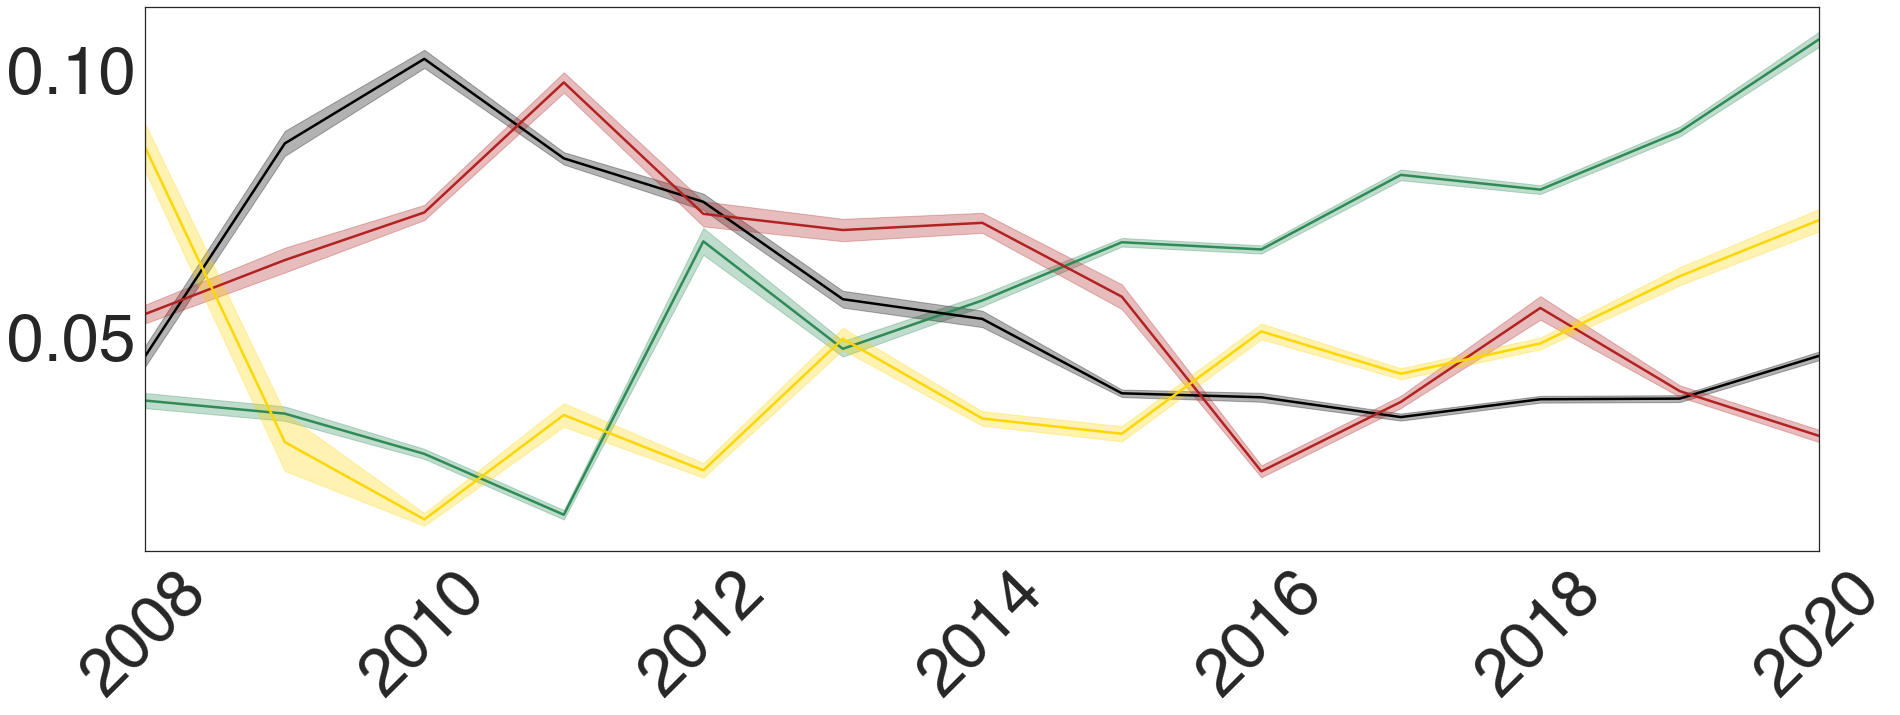

In [13]:
sns.set(style="white", font="Helvetica", font_scale=6) 
by = "year"
plot_heatmaps_all_four_together(by, figsize=(30, 10), T=False, countN=10)

In [14]:
# by = "quarter"

# plot_heatmaps_all_four_together(by, figsize=(30, 10), T=False, countN=10)

## Unemployment rate

In [15]:
unr = pd.read_csv('../../data/us_unemployment_rate.csv', parse_dates=['DATE'])

In [16]:
unr = unr[ (unr['DATE']> '2008-06-01') & (unr['DATE'] < '2020-03-01') ]

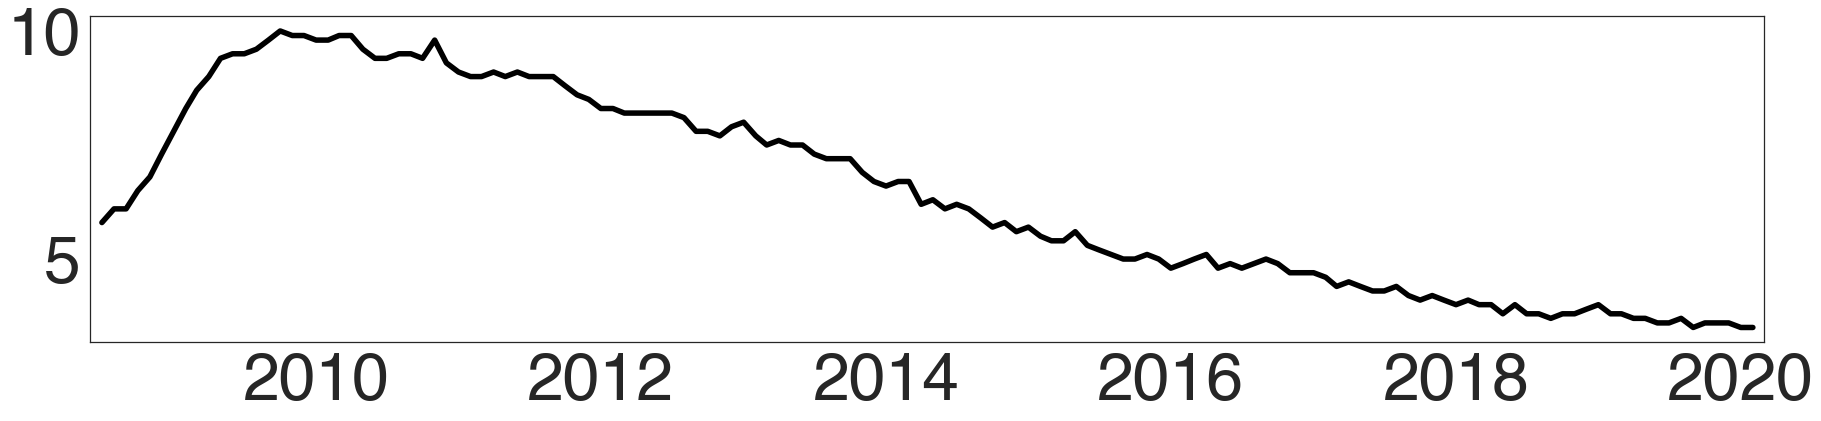

In [17]:
fig, ax = plt.subplots(figsize=(30, 6))
sns.set(style="white", font="Helvetica", font_scale=5) 
ax = sns.lineplot(data=unr, x="DATE", y='UNRATE', color='black',\
                  linewidth = 5.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xlim(['2008-06-01','2020-03-01'])
# plt.tight_layout()
# ax.set_xticks(['2008','2010','2012','2014','2016','2018','2020'])
plt.savefig('../../results/unr.png', dpi=100)